In [1]:
import boto3
import botocore
import functools
from IPython.core.display import display, HTML
from iterdub import iterdub as ib
from iterpop import iterpop as ip
import itertools as it
import json
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from pandas.util import hash_pandas_object
import seaborn as sns
from teeplot import teeplot as tp


In [2]:
from dishpylib.pyanalysis import calc_loglikelihoods_by_num_sets
from dishpylib.pyanalysis import count_hands_with_k_or_more_sets
from dishpylib.pyanalysis import count_hands_without_k_or_more_sets
from dishpylib.pyanalysis import estimate_interpolation_complexity
from dishpylib.pyanalysis import calc_loglikelihoods_over_set_sizes
from dishpylib.pyhelpers import get_env_context
from dishpylib.pyhelpers import get_git_revision_hash
from dishpylib.pyhelpers import make_timestamp
from dishpylib.pyhelpers import NumpyEncoder
from dishpylib.pyhelpers import preprocess_competition_fitnesses
from dishpylib.pyhelpers import print_runtime


In [3]:
print_runtime()


context: ci
hostname: runnervmyfcvg
interpreter: 3.10.12 (main, Aug 15 2025, 14:32:43) [GCC 11.4.0]
notebook name: 2025-09-12-abiotic_complexity
notebook path: /home/runner/work/oee4/oee4/binder/2025-09-12-abiotic_complexity.ipynb
revision: bdac574
timestamp: 2025-09-12T15:55:04Z00:00

IPython==7.16.1
packaging==25.0


<ipython-input-3-4d790cf6450f>:1: DeprecatedWarning: print_runtime is deprecated. use nbmetalog package instead
  print_runtime()


In [4]:
teeplot_subdir = "2025-09-12-abiotic_complexity"


In [5]:
import boto3
import botocore
import functools
import pandas as pd

from dishpylib.pyhelpers import fit_control_t_distns

@functools.lru_cache
def get_control_t_distns( bucket, endeavor, stint ):

    s3_handle = boto3.resource(
        's3',
        region_name="us-east-2",
        config=botocore.config.Config(
            signature_version=botocore.UNSIGNED,
        ),
    )
    bucket_handle = s3_handle.Bucket(bucket)

    control_competitions, = bucket_handle.objects.filter(
        Prefix=f'endeavor={endeavor}/control-competitions/stage=2+what=collated/stint={stint}/',
    )

    control_df = pd.read_csv(
        f's3://{bucket}/{control_competitions.key}',
    )

    return fit_control_t_distns(control_df[
        control_df["Root ID"] == 1
    ].copy())


In [6]:
import functools
from iterpop import iterpop as ip
from scipy import stats


def preprocess_competition_fitnesses(competitions_df, control_fits_df):
    # preprocess data
    @functools.lru_cache
    def h0_fit(series):
        return ip.popsingleton(
            control_fits_df[control_fits_df["Series"] == series].to_dict(
                orient="records",
            )
        )

    competitions_df["p"] = competitions_df.apply(
        lambda row: stats.t.cdf(
            row["Fitness Differential"],
            h0_fit(row["genome series"])["Fit Degrees of Freedom"],
            loc=h0_fit(row["genome series"])["Fit Loc"],
            scale=h0_fit(row["genome series"])["Fit Scale"],
        ),
        axis=1,
    )
    competitions_df["Is Less Fit"] = competitions_df["p"] < 1.0 / 40
    competitions_df["Is More Fit"] = competitions_df["p"] > (1.0 -  1.0 / 40)
    competitions_df["Is Neutral"] = ~(
        competitions_df["Is Less Fit"] | competitions_df["Is More Fit"]
    )
    competitions_df["Relative Fitness"] = competitions_df.apply(
        lambda row: (
            "Significantly Advantageous"
            if row["Is More Fit"]
            else (
                "Significantly Deleterious" if row["Is Less Fit"] else "Neutral"
            )
        ),
        axis=1,
    )

    return competitions_df


# get data


In [7]:
s3_handle = boto3.resource(
    's3',
    region_name="us-east-2",
    config=botocore.config.Config(
        signature_version=botocore.UNSIGNED,
    ),
)
bucket_handle = s3_handle.Bucket('prq49')

dfs = []
for stint in range(1, 101):
# for stint in (19,):
    print(stint)
    series_profiles, = bucket_handle.objects.filter(
        Prefix=f'endeavor=16/variant-competitions/stage=3+what=collated/stint={stint}/',
    )
    control_fits_df = get_control_t_distns('prq49', 16, stint)
    df = pd.read_csv(
        f's3://prq49/{series_profiles.key}',
        compression='xz',
    )
    df["Stint"] = stint
    dfdigest = '{:x}'.format( hash_pandas_object( df ).sum() )
    print(dfdigest)
    df = preprocess_competition_fitnesses(df, control_fits_df)
    dfs.append(df)


1
4cf9fc7a2f23893e
2
58aa8d1daac43f0f
3
-1b71e1b49fc95842
4
-2a72237f852e4f52
5
781ef98f34410df7
6
4a83007cdf328934
7
-1bb3752f4c15e543
8
-3b8804c153d27a26
9
85a84d07546bae0
10
-a01a37d40282326
11
39226133d482c4ec
12
59543eab7579198c
13
-4342983ea422fdac
14
-7ac79f6c2c34df5b
15
41d0c3ab88c67113
16
-721d3f230ddfb161
17
-7208d22ad457ec13
18
4fbc33824eae23d4
19
6e08efb8f7cd35eb
20
-1a23f2549aa6c9d5
21
4fd736d41743cbf
22
e14099eb4a5c852
23
74f00b0b39120d0b
24
-973dce1e8317785
25
1e6a193aa11575f2
26
15b7e07eb2153f77
27
-392ec9346f9c45bf
28
-3f5346562a9d1ef1
29
433470afb2031d62
30
ab792343cd196ee
31
-5b8e3c0806432701
32
438767bb38c61948
33
75e7b4fa929a2763
34
-66a220fb1e7ad703
35
-275f6d32620029df
36
-61eff4519bc1b352
37
-7ed65867b10a6de3
38
19ec0548e1bc9881
39
-456edb9c3a2282d7
40
75bf647f9433af65
41
-127897bac22ead3c
42
-375d9926f1f2c9f0
43
2ab42035c57a05e8
44
66aa38f87c0d3500
45
-66c62c0bd189ad8e
46
-22b88db54549bd7e
47
fb82ac2eded6175
48
-408874b10a1082ce
49
-6651761b50cb4bb5
50
-6e89596

In [8]:
df = pd.concat(dfs)


In [9]:
dfx = df[
    df["Root ID"] == 1
].groupby("Stint").agg(
    {
        "Is More Fit": "sum",
        "Is Less Fit": "sum",
        "Is Neutral": "sum",
    },
)
dfx


,Is More Fit,Is Less Fit,Is Neutral
Stint,,,
1,3,8,37
2,2,20,21
3,0,10,42
4,5,19,37
5,1,19,32
...,...,...,...
96,3,27,111
97,0,38,230
98,0,34,674


In [10]:
dfx = dfx.reset_index(drop=False)


Text(0, 0.5, 'Num Sites')

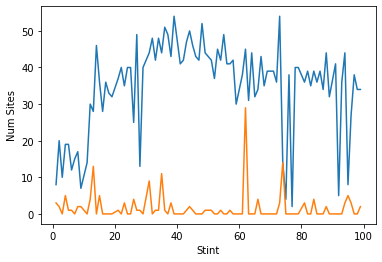

In [11]:
sns.lineplot(
    data=dfx[
        (dfx["Stint"] % 10) != 0
    ],
    markers=True,
    x="Stint",
    y="Is Less Fit",
)
sns.lineplot(
    data=dfx[
        (dfx["Stint"] % 10) != 0
    ],
    markers=True,
    x="Stint",
    y="Is More Fit",
)
plt.gca().set_ylabel("Num Sites")
